In [1]:
from transformers import pipeline


from FlagEmbedding import FlagReranker
import mailbox
from datetime import datetime
import pandas as pd
import re
import matplotlib.pyplot as plt

# Initialize for the language labeling

model_ckpt = "papluca/xlm-roberta-base-language-detection"
pipe = pipeline("text-classification", model=model_ckpt)
#pipe(text, top_k=1, truncation=True)


# Initialize the formality analysis model
reranker = FlagReranker('BAAI/bge-reranker-v2-m3', use_fp16=True)

# Path to your mbox file
mbox_file_path = 'gpt_output_all.xlsx'




# Open the mbox file

# Create DataFrame from extracted data


C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [36]:
import re

# Function to clean and parse the email body
def clean_email_body(email):
    """
    Cleans the email body by removing quoted replies, line breaks, and unnecessary spaces.
    
    Args:
        email (str): Full email text including subject and body.
        
    Returns:
        dict: Parsed email with 'subject' and 'body'.
    """
    # Split email into subject and body
    subject_match = re.search(r'Subject: (.+)', email)
    subject = subject_match.group(1).strip() if subject_match else "No Subject"

    # Extract the body by removing the subject line
    body = re.sub(r'Subject: .+\n', '', email, count=1).strip()

    # Clean the body (remove quoted lines, fix line breaks, and trim spaces)
    cleaned_body = re.sub(r'(?m)^>.*$', '', body)  # Remove quoted lines
    cleaned_body = re.sub(r'\r\n', ' ', cleaned_body)  # Normalize line breaks
    cleaned_body = re.sub(r'\s+', ' ', cleaned_body)  # Replace multiple spaces with one
    return {'subject': subject, 'body': cleaned_body.strip()}

# Function to compute formality score and classify
def get_formality_class(text):
    formal_score = reranker.compute_score(['Formal', text], normalize=True)[0]
    informal_score = reranker.compute_score(['Informal', text], normalize=True)[0]
    if formal_score >= informal_score :
        return ('Formal', (formal_score/informal_score))
    elif formal_score < informal_score:
        return ('Informal',(formal_score/informal_score))
    else:
        return 'Neutral'

# Example email to test
email_text = """Subject: Meldung 10 Enrollment Fee Transfer

Dear Student,

I hope this message finds you well. I am writing to provide information regarding the submission of Meldung 10 and the necessary steps for your enrollment fee transfer.

To start with, we understand that the process of enrollment might be overwhelming, and the paperwork can be quite extensive. However, the Meldung 10 form is relatively straightforward and doesn't require a significant amount of time to complete. We believe you will find it sufficiently concise and easy to manage. 

As for the transfer of the enrollment fee, we have made all the necessary arrangements to ensure a smooth process. The procedures in place are not lengthy and will not take up too much of your time. Once you have completed the Meldung 10 form, the transfer can be completed around noon or early afternoon, which we've found to be a convenient time for most students.

In terms of formality, while we recognize the importance of professionalism, we also value an approachable and amiable atmosphere. As such, feel free to reach out to our team if you have any questions or concerns. We are here to assist you with any inquiries you may have regarding this process.

Looking forward to your successful enrollment.

Best regards,

[Your Name]
[Your Position]
"""

# Run the functions
parsed_email = clean_email_body(email_text)
formality_class, formality_ratio = get_formality_class(parsed_email['body'])

# Output the results
print("Parsed Email:", parsed_email)
print(f"Formality Classification: {formality_class}, Ratio: {formality_ratio}")


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 143.78it/s]
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\tokenization_utils_base.py:2888: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 501.35it/s]


Parsed Email: {'subject': 'Meldung 10 Enrollment Fee Transfer', 'body': "Dear Student, I hope this message finds you well. I am writing to provide information regarding the submission of Meldung 10 and the necessary steps for your enrollment fee transfer. To start with, we understand that the process of enrollment might be overwhelming, and the paperwork can be quite extensive. However, the Meldung 10 form is relatively straightforward and doesn't require a significant amount of time to complete. We believe you will find it sufficiently concise and easy to manage. As for the transfer of the enrollment fee, we have made all the necessary arrangements to ensure a smooth process. The procedures in place are not lengthy and will not take up too much of your time. Once you have completed the Meldung 10 form, the transfer can be completed around noon or early afternoon, which we've found to be a convenient time for most students. In terms of formality, while we recognize the importance of pr

In [37]:
gpt_output = pd.read_excel("gpt_output_all.xlsx")

In [38]:
gpt_output.head()

,row_index,topic,subject,original_body,prompt_used,gpt_generated_body
0,0,Empty,Adobe Scan 25 Haz 2024.pdf,Adobe Scan 25 Haz 2024.pdf: https://acrobat.ad...,Skipped because topic is 'Empty'.,NaN
1,1,Accommodation,Broken showerhead,"Dear janitor, My name is Arda Aydın. I live in...",Write an email similar to the following exampl...,Subject: Issue with Showerhead in Unit 12B\n\n...
2,2,Empty,NaN,NaN,Skipped because topic is 'Empty'.,NaN
3,3,Empty,\n =?utf-8?B?TCdPcsOpYWwgVMO8cmtpeWUgfCBGb3Rvx...,NaN,Skipped because topic is 'Empty'.,NaN
4,4,Academic,Meldung 10 and money transfer for enrollment,"Hello dear exchange students team, I would lik...",Write an email similar to the following exampl...,Subject: Meldung 10 Enrollment Fee Transfer\n\...


In [39]:
data

,row_index,topic,subject,original_body,prompt_used,gpt_generated_body
0,0,Empty,Adobe Scan 25 Haz 2024.pdf,Adobe Scan 25 Haz 2024.pdf: https://acrobat.ad...,Skipped because topic is 'Empty'.,NaN
1,1,Accommodation,Broken showerhead,"Dear janitor, My name is Arda Aydın. I live in...",Write an email similar to the following exampl...,Subject: Issue with Showerhead in Unit 12B\n\n...
2,2,Empty,NaN,NaN,Skipped because topic is 'Empty'.,NaN
3,3,Empty,\n =?utf-8?B?TCdPcsOpYWwgVMO8cmtpeWUgfCBGb3Rvx...,NaN,Skipped because topic is 'Empty'.,NaN
4,4,Academic,Meldung 10 and money transfer for enrollment,"Hello dear exchange students team, I would lik...",Write an email similar to the following exampl...,Subject: Meldung 10 Enrollment Fee Transfer\n\...
...,...,...,...,...,...,...
506,506,Other Help,ie311 quiz answer key,"Merhaba Arda, ben quiz ikinin cevap anahtarına...",Write an email similar to the following exampl...,Subject: Clarification on ie311 Quiz Answer Ke...
507,507,Empty,Activate your vocab.,NaN,Skipped because topic is 'Empty'.,NaN
508,508,Empty,NaN,NaN,Skipped because topic is 'Empty'.,NaN
509,509,Empty,NaN,NaN,Skipped because topic is 'Empty'.,NaN


In [42]:
import pandas as pd
import re

# Function to compute formality score and classify the text
def get_formality_class(text):
    """
    Computes formality score and classifies the text as 'Formal' or 'Informal'.
    Returns a tuple: (classification, ratio).
    """
    if not isinstance(text, str) or text.strip() == "":
        return ("Unknown", 0)  # Handle non-string or empty texts
    
    # Calculate scores using reranker
    formal_score = reranker.compute_score(['Formal', text], normalize=True)[0]
    informal_score = reranker.compute_score(['Informal', text], normalize=True)[0]
    
    if formal_score >= informal_score:
        return ("Formal", formal_score / (informal_score ))  # Add small constant to avoid division by zero
    else:
        return ("Informal", formal_score / (informal_score ))

# Function to parse gpt_generated_body
def parse_gpt_generated_body(generated_body):
    """
    Parses the gpt_generated_body column into subject and body.
    Returns a dictionary with 'parsed_subject' and 'parsed_body'.
    """
    if pd.isnull(generated_body):  # Handle missing values
        return {"parsed_subject": None, "parsed_body": None}
    
    # Split by the first line break to separate subject and body
    split_content = re.split(r'\n', generated_body, maxsplit=1)
    parsed_subject = split_content[0].strip()
    parsed_body = split_content[1].strip() if len(split_content) > 1 else None
    return {"parsed_subject": parsed_subject, "parsed_body": parsed_body}


# Apply parsing to the gpt_generated_body column
parsed_results = gpt_output['gpt_generated_body'].apply(parse_gpt_generated_body)

# Create new columns for parsed subject and body
gpt_output['parsed_subject'] = parsed_results.apply(lambda x: x['parsed_subject'])
gpt_output['parsed_body'] = parsed_results.apply(lambda x: x['parsed_body'])

# Apply formality scoring to parsed body
formality_results = gpt_output['parsed_body'].apply(get_formality_class)

# Create new columns for formality classification and ratio
gpt_output['formality'] = formality_results.apply(lambda x: x[0])
gpt_output['formality_ratio'] = formality_results.apply(lambda x: x[1])

# Display the updated DataFrame with new columns
print(gpt_output[['parsed_subject', 'parsed_body', 'formality', 'formality_ratio']].head())

# Save the updated dataset to a new Excel file



pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 168.17it/s]
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\tokenization_utils_base.py:2888: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.46it/s]


                                parsed_subject  \
0                                         None   
1   Subject: Issue with Showerhead in Unit 12B   
2                                         None   
3                                         None   
4  Subject: Meldung 10 Enrollment Fee Transfer   

                                         parsed_body formality  \
0                                               None   Unknown   
1  Dear Mr. Patterson,\n\nI hope this message fin...    Formal   
2                                               None   Unknown   
3                                               None   Unknown   
4  Dear Student,\n\nI hope this message finds you...    Formal   

   formality_ratio  
0         0.000000  
1         2.806518  
2         0.000000  
3         0.000000  
4        18.803555  


In [43]:
df = pd.DataFrame(gpt_output)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_28840\1698709765.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_emails['body_length'] = valid_emails['parsed_body'].apply(len)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_28840\1698709765.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_emails['word_count'] = valid_emails['parsed_body'].apply(lambda x: len(x.split()))


Formality Distribution:
formality
Formal      167
Informal      7
Name: count, dtype: int64


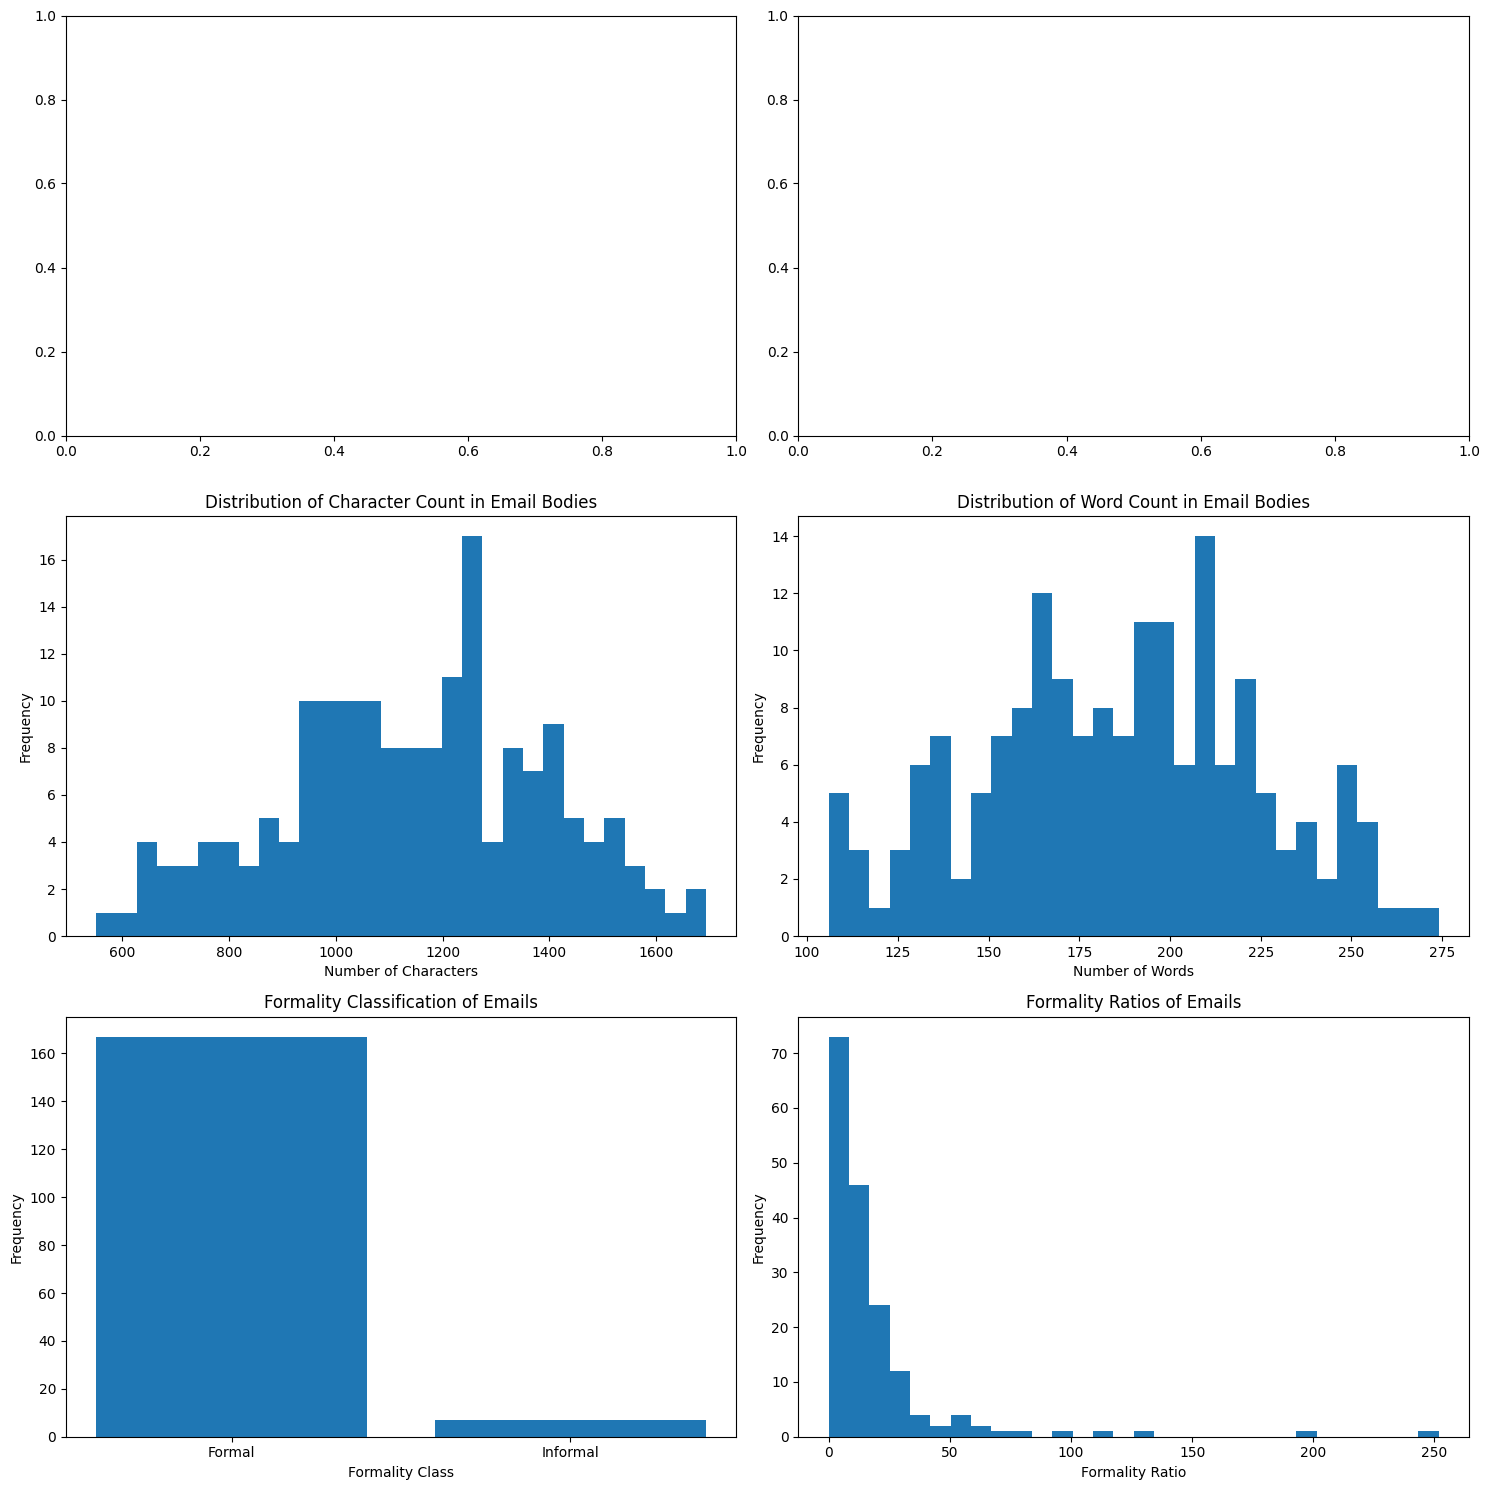

In [44]:
valid_emails = df[df['parsed_body'].notnull()]

# Calculate body length and word count for valid emails
valid_emails['body_length'] = valid_emails['parsed_body'].apply(len)
valid_emails['word_count'] = valid_emails['parsed_body'].apply(lambda x: len(x.split()))

# Formality classification summary
formality_counts = valid_emails['formality'].value_counts()
print(f"Formality Distribution:\n{formality_counts}")

# Plotting distributions
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Character count distribution
axs[1, 0].hist(valid_emails['body_length'], bins=30)
axs[1, 0].set_xlabel('Number of Characters')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].set_title('Distribution of Character Count in Email Bodies')

# Word count distribution
axs[1, 1].hist(valid_emails['word_count'], bins=30)
axs[1, 1].set_xlabel('Number of Words')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_title('Distribution of Word Count in Email Bodies')

# Formality distribution (bar chart)
axs[2, 0].bar(formality_counts.index, formality_counts.values)
axs[2, 0].set_xlabel('Formality Class')
axs[2, 0].set_ylabel('Frequency')
axs[2, 0].set_title('Formality Classification of Emails')

# Formality ratio distribution (histogram)
axs[2, 1].hist(valid_emails['formality_ratio'], bins=30)
axs[2, 1].set_xlabel('Formality Ratio')
axs[2, 1].set_ylabel('Frequency')
axs[2, 1].set_title('Formality Ratios of Emails')

plt.tight_layout()
plt.show()


In [45]:
df.to_json('Not_Reply_gpt.json', orient='records', date_format='iso')


In [46]:
from transformers import pipeline
import pandas as pd

In [47]:
categories = ["Academic", "Empty", "Work & Job Applications", "Other Help", "Accommodation", "Complaints"]


In [48]:
classifier = pipeline("zero-shot-classification", model="joeddav/xlm-roberta-large-xnli")


Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavio

In [49]:
def classify_topic(text):
    """
    Classify the topic of an email using a multilingual zero-shot classifier.
    Returns the top predicted label.
    """
    # Return 'Empty' for empty or null text
    if not text or text.strip() == "":
        return "Empty", 1.0  # Assign "Empty" with full confidence

    result = classifier(text, categories, multi_label=False)
    return result['labels'][0], result['scores'][0]  # Top label and its confidence score


In [50]:
df.head()

,row_index,topic,subject,original_body,prompt_used,gpt_generated_body,parsed_subject,parsed_body,formality,formality_ratio
0,0,Empty,Adobe Scan 25 Haz 2024.pdf,Adobe Scan 25 Haz 2024.pdf: https://acrobat.ad...,Skipped because topic is 'Empty'.,NaN,None,None,Unknown,0.000000
1,1,Accommodation,Broken showerhead,"Dear janitor, My name is Arda Aydın. I live in...",Write an email similar to the following exampl...,Subject: Issue with Showerhead in Unit 12B\n\n...,Subject: Issue with Showerhead in Unit 12B,"Dear Mr. Patterson,\n\nI hope this message fin...",Formal,2.806518
2,2,Empty,NaN,NaN,Skipped because topic is 'Empty'.,NaN,None,None,Unknown,0.000000
3,3,Empty,\n =?utf-8?B?TCdPcsOpYWwgVMO8cmtpeWUgfCBGb3Rvx...,NaN,Skipped because topic is 'Empty'.,NaN,None,None,Unknown,0.000000
4,4,Academic,Meldung 10 and money transfer for enrollment,"Hello dear exchange students team, I would lik...",Write an email similar to the following exampl...,Subject: Meldung 10 Enrollment Fee Transfer\n\...,Subject: Meldung 10 Enrollment Fee Transfer,"Dear Student,\n\nI hope this message finds you...",Formal,18.803555


In [52]:
if 'gpt_generated_body' in df.columns:
    df['gpt_generated_body'] = df['gpt_generated_body'].fillna("")  # Replace NaN with empty strings

# Classify topics
df['topic'], df['topic_confidence'] = zip(*df['gpt_generated_body'].apply(classify_topic))

# Display a summary of topic distribution
topic_summary = df['topic'].value_counts()
print(f"Topic Distribution:\n{topic_summary}")

# Save results to a CSV for further inspection
df.to_csv("classified_emails_gpt.csv", index=False)

Topic Distribution:
topic
Empty                      343
Academic                    62
Accommodation               56
Complaints                  43
Work & Job Applications      5
Other Help                   2
Name: count, dtype: int64


In [53]:
df[:20]

,row_index,topic,subject,original_body,prompt_used,gpt_generated_body,parsed_subject,parsed_body,formality,formality_ratio,topic_confidence
0,0,Empty,Adobe Scan 25 Haz 2024.pdf,Adobe Scan 25 Haz 2024.pdf: https://acrobat.ad...,Skipped because topic is 'Empty'.,,None,None,Unknown,0.000000,1.000000
1,1,Complaints,Broken showerhead,"Dear janitor, My name is Arda Aydın. I live in...",Write an email similar to the following exampl...,Subject: Issue with Showerhead in Unit 12B\n\n...,Subject: Issue with Showerhead in Unit 12B,"Dear Mr. Patterson,\n\nI hope this message fin...",Formal,2.806518,0.189386
2,2,Empty,NaN,NaN,Skipped because topic is 'Empty'.,,None,None,Unknown,0.000000,1.000000
3,3,Empty,\n =?utf-8?B?TCdPcsOpYWwgVMO8cmtpeWUgfCBGb3Rvx...,NaN,Skipped because topic is 'Empty'.,,None,None,Unknown,0.000000,1.000000
4,4,Academic,Meldung 10 and money transfer for enrollment,"Hello dear exchange students team, I would lik...",Write an email similar to the following exampl...,Subject: Meldung 10 Enrollment Fee Transfer\n\...,Subject: Meldung 10 Enrollment Fee Transfer,"Dear Student,\n\nI hope this message finds you...",Formal,18.803555,0.218397
5,5,Accommodation,After Mobility Requirements,"Merhaba, Gerekli evrakları şu an tarafınıza te...",Write an email similar to the following exampl...,Subject: Following Up on Your Mobility Needs\n...,Subject: Following Up on Your Mobility Needs,"Dear Team,\n\nI hope this message finds you we...",Formal,15.497070,0.748073
6,6,Empty,NaN,NaN,Skipped because topic is 'Empty'.,,None,None,Unknown,0.000000,1.000000
7,7,Empty,NaN,"Merhabalar, Bu maili Sabancı üniversitesi öğre...",Skipped because topic is 'Empty'.,,None,None,Unknown,0.000000,1.000000
8,8,Academic,Meeting,"Hi Arda, Let me know if you have time Later th...",Write an email similar to the following exampl...,"Subject: Scheduling a Meeting \n\nDear Team,\n...",Subject: Scheduling a Meeting,"Dear Team,\n\nI hope this message finds you we...",Formal,30.776670,0.672430
9,9,Empty,NaN,NaN,Skipped because topic is 'Empty'.,,None,None,Unknown,0.000000,1.000000


In [ ]:
# Flag anything mentioning "Adobe" in the body
df['is_just_visual'] = df['gpt_generated_body'].str.contains(r'\bAdobe\b', case=False, na=False)

# Override the topic for these "visual" emails
df.loc[df['is_just_visual'], 'topic'] = "Empty"
df.loc[df['is_just_visual'], 'topic_confidence'] = 1.0

# Display a summary of visual-only emails
visual_summary = df['is_just_visual'].value_counts()
print(f"Visual Email Distribution:\n{visual_summary}")

# Group by topics and analyze
topic_analysis = df.groupby('topic').apply(
    lambda x: pd.Series({
        'total_emails': len(x),
        'visual_only_emails': x['is_just_visual'].sum(),
        'visual_only_percentage': (x['is_just_visual'].mean() * 100).round(2),
        'average_word_count': x['word_count'].mean().round(2) if 'word_count' in x else None,
    })
)

# Display the topic analysis
print("Topic Analysis:")
print(topic_analysis)

# Save the enhanced DataFrame for further inspection

# Save the topic analysis summary
topic_analysis.to_csv("topic_analysis_summary.csv")


Visual Email Distribution:
is_just_visual
False    511
Name: count, dtype: int64
Topic Analysis:
                         total_emails  visual_only_emails  \
topic                                                       
Academic                         62.0                 0.0   
Accommodation                    56.0                 0.0   
Complaints                       43.0                 0.0   
Empty                           343.0                 0.0   
Other Help                        2.0                 0.0   
Work & Job Applications           5.0                 0.0   

                         visual_only_percentage  average_word_count  
topic                                                                
Academic                                    0.0                 NaN  
Accommodation                               0.0                 NaN  
Complaints                                  0.0                 NaN  
Empty                                       0.0                 

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_28840\683837741.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  topic_analysis = df.groupby('topic').apply(


In [56]:
import seaborn as sns


In [60]:
df.head()

,row_index,topic,subject,original_body,prompt_used,gpt_generated_body,parsed_subject,parsed_body,formality,formality_ratio,topic_confidence,is_just_visual
0,0,Empty,Adobe Scan 25 Haz 2024.pdf,Adobe Scan 25 Haz 2024.pdf: https://acrobat.ad...,Skipped because topic is 'Empty'.,,None,None,Unknown,0.000000,1.000000,False
1,1,Complaints,Broken showerhead,"Dear janitor, My name is Arda Aydın. I live in...",Write an email similar to the following exampl...,Subject: Issue with Showerhead in Unit 12B\n\n...,Subject: Issue with Showerhead in Unit 12B,"Dear Mr. Patterson,\n\nI hope this message fin...",Formal,2.806518,0.189386,False
2,2,Empty,NaN,NaN,Skipped because topic is 'Empty'.,,None,None,Unknown,0.000000,1.000000,False
3,3,Empty,\n =?utf-8?B?TCdPcsOpYWwgVMO8cmtpeWUgfCBGb3Rvx...,NaN,Skipped because topic is 'Empty'.,,None,None,Unknown,0.000000,1.000000,False
4,4,Academic,Meldung 10 and money transfer for enrollment,"Hello dear exchange students team, I would lik...",Write an email similar to the following exampl...,Subject: Meldung 10 Enrollment Fee Transfer\n\...,Subject: Meldung 10 Enrollment Fee Transfer,"Dear Student,\n\nI hope this message finds you...",Formal,18.803555,0.218397,False


In [63]:
df['body_length'] = df['gpt_generated_body'].apply(len)
df['word_count'] = df['gpt_generated_body'].apply(lambda x: len(x.split()))


In [70]:
df.to_excel("enhanced_classified_emails_gpt.xlsx", index=False)


In [64]:
df.head()

,row_index,topic,subject,original_body,prompt_used,gpt_generated_body,parsed_subject,parsed_body,formality,formality_ratio,topic_confidence,is_just_visual,body_length,word_count
0,0,Empty,Adobe Scan 25 Haz 2024.pdf,Adobe Scan 25 Haz 2024.pdf: https://acrobat.ad...,Skipped because topic is 'Empty'.,,None,None,Unknown,0.000000,1.000000,False,0,0
1,1,Complaints,Broken showerhead,"Dear janitor, My name is Arda Aydın. I live in...",Write an email similar to the following exampl...,Subject: Issue with Showerhead in Unit 12B\n\n...,Subject: Issue with Showerhead in Unit 12B,"Dear Mr. Patterson,\n\nI hope this message fin...",Formal,2.806518,0.189386,False,788,133
2,2,Empty,NaN,NaN,Skipped because topic is 'Empty'.,,None,None,Unknown,0.000000,1.000000,False,0,0
3,3,Empty,\n =?utf-8?B?TCdPcsOpYWwgVMO8cmtpeWUgfCBGb3Rvx...,NaN,Skipped because topic is 'Empty'.,,None,None,Unknown,0.000000,1.000000,False,0,0
4,4,Academic,Meldung 10 and money transfer for enrollment,"Hello dear exchange students team, I would lik...",Write an email similar to the following exampl...,Subject: Meldung 10 Enrollment Fee Transfer\n\...,Subject: Meldung 10 Enrollment Fee Transfer,"Dear Student,\n\nI hope this message finds you...",Formal,18.803555,0.218397,False,1303,215


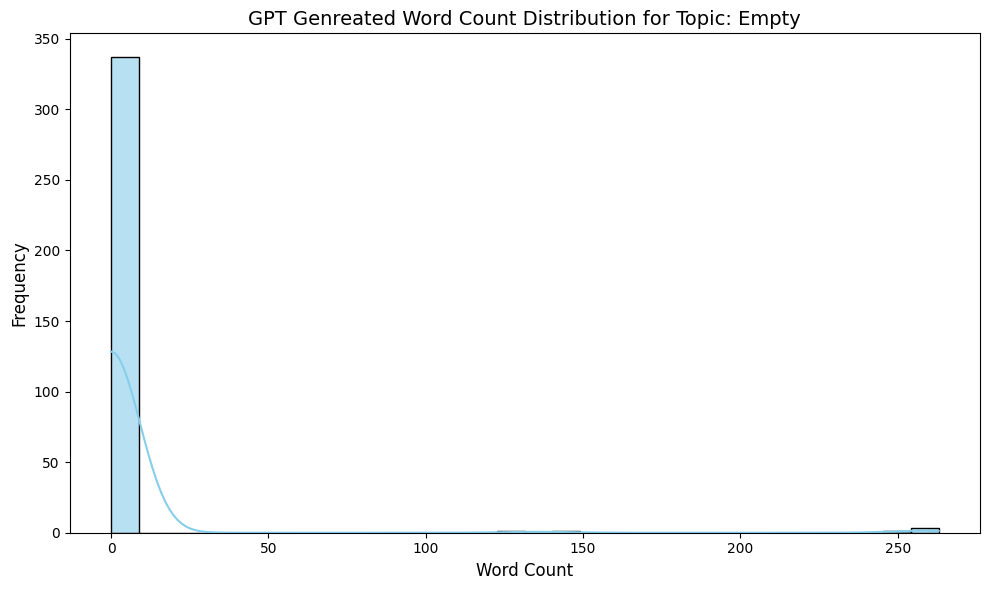

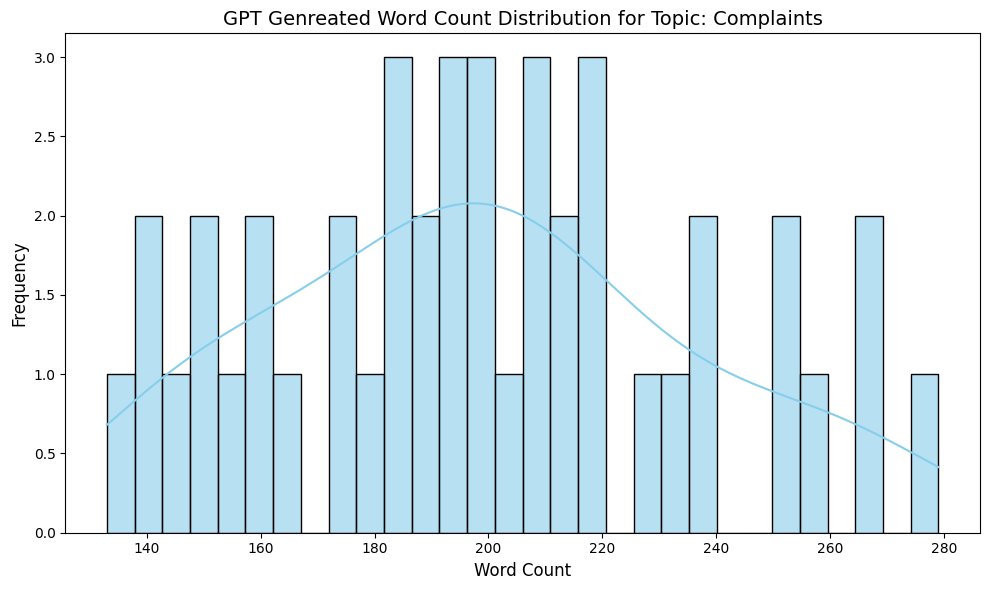

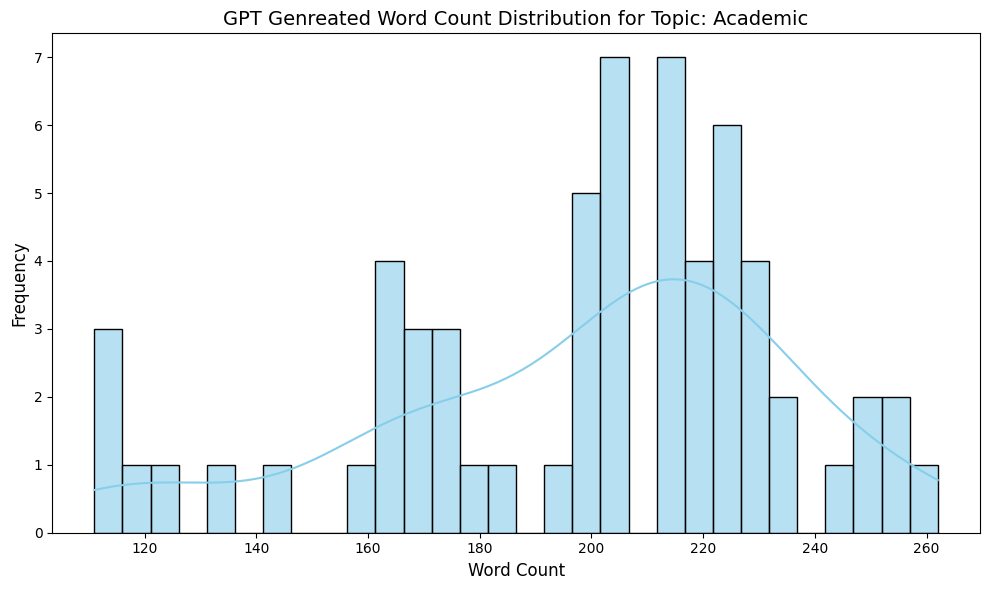

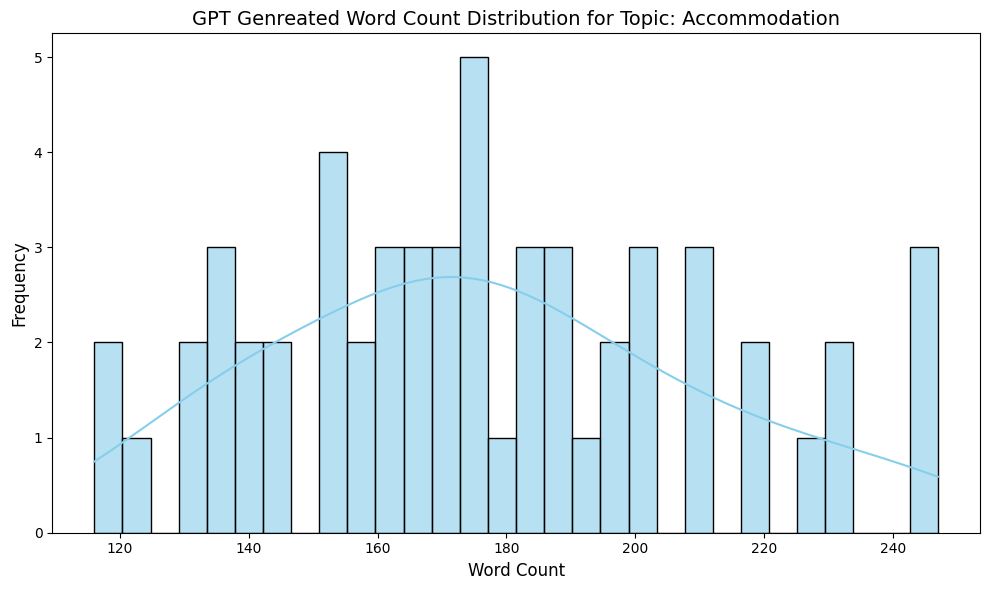

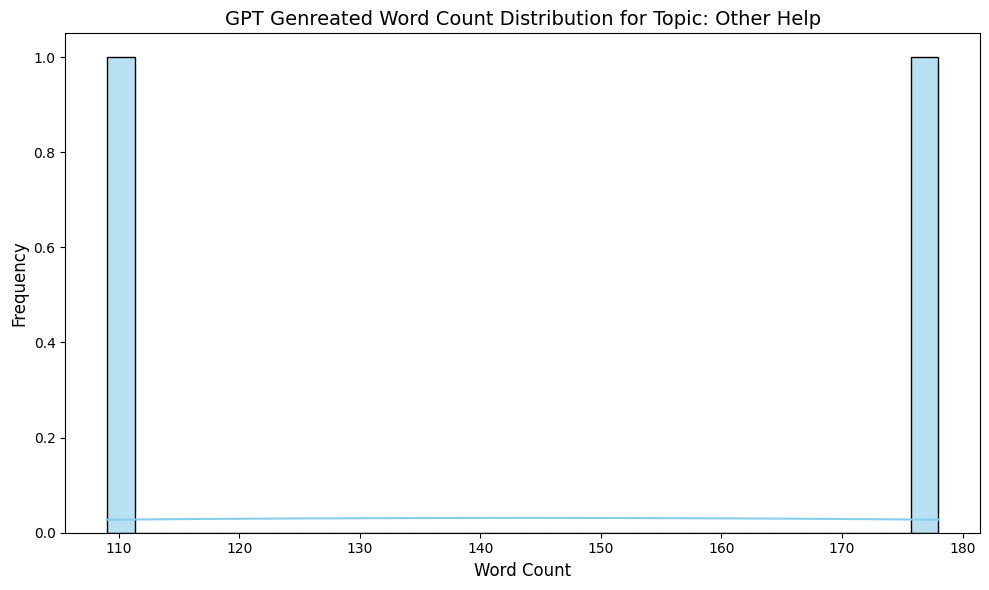

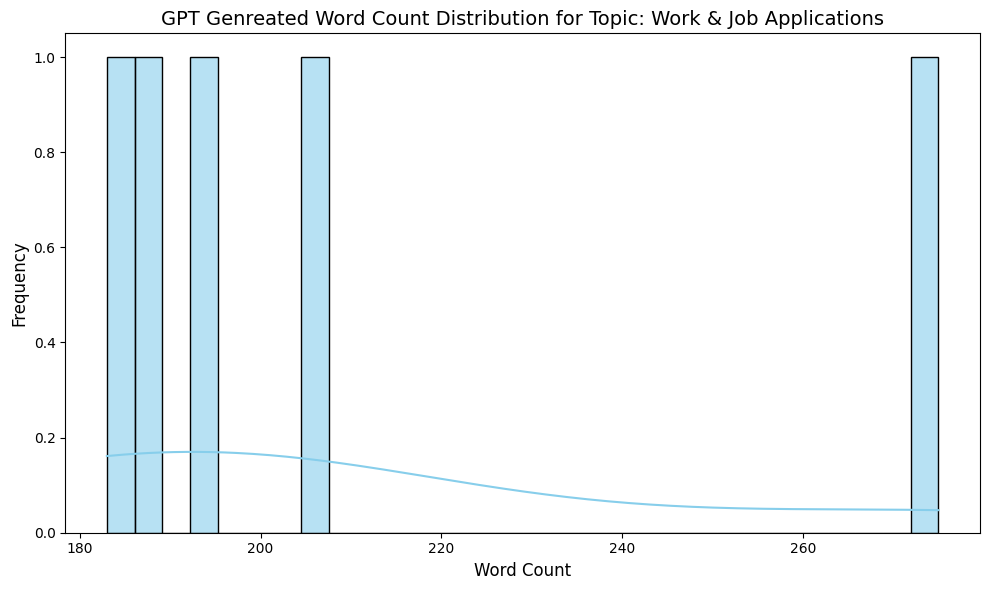

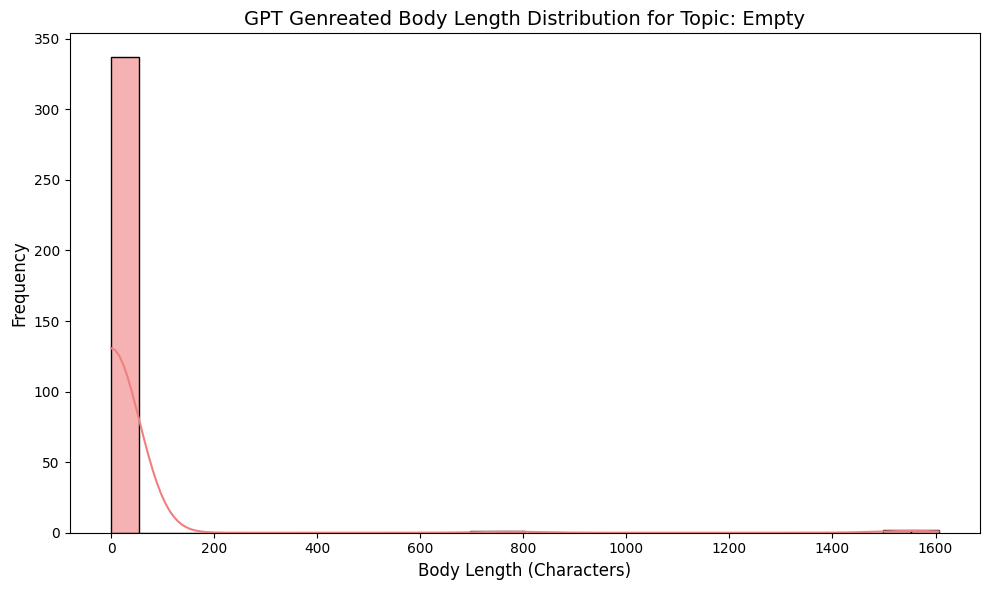

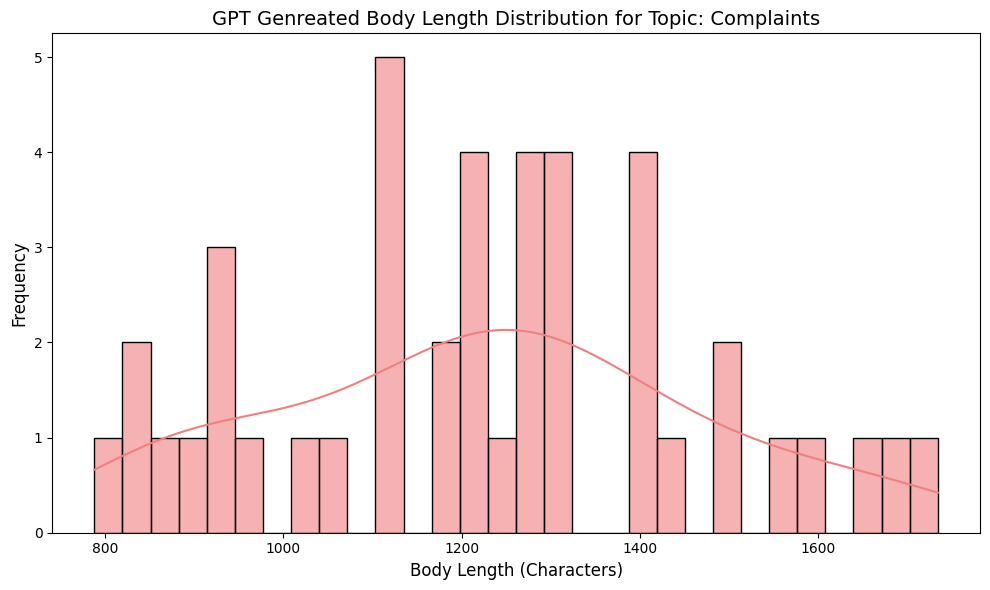

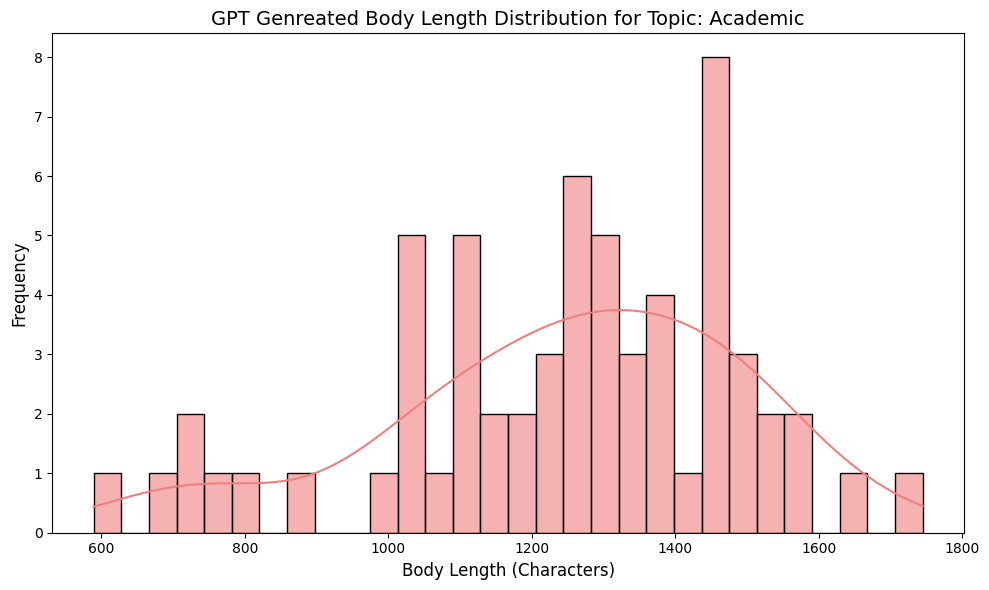

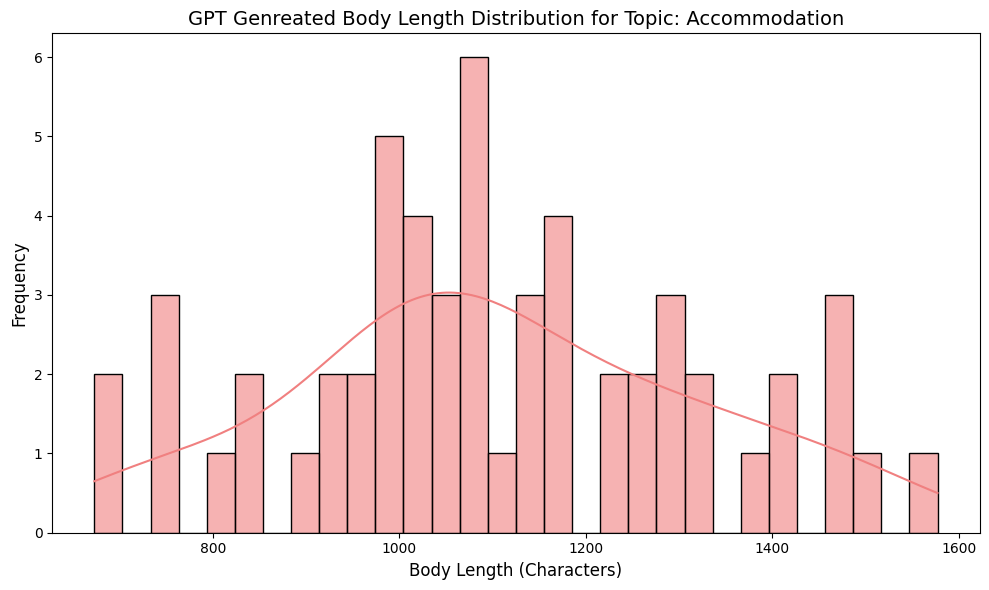

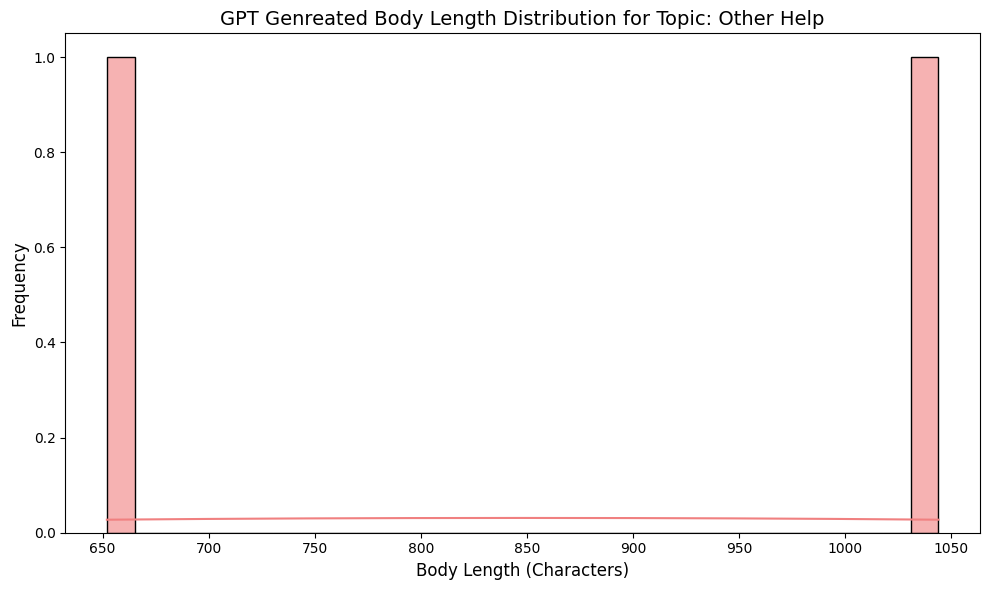

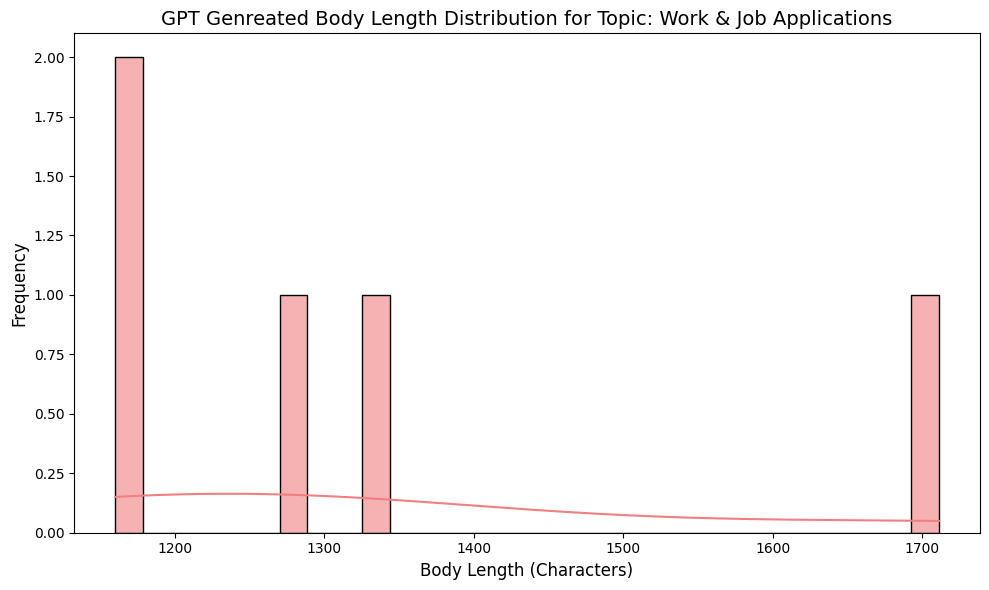

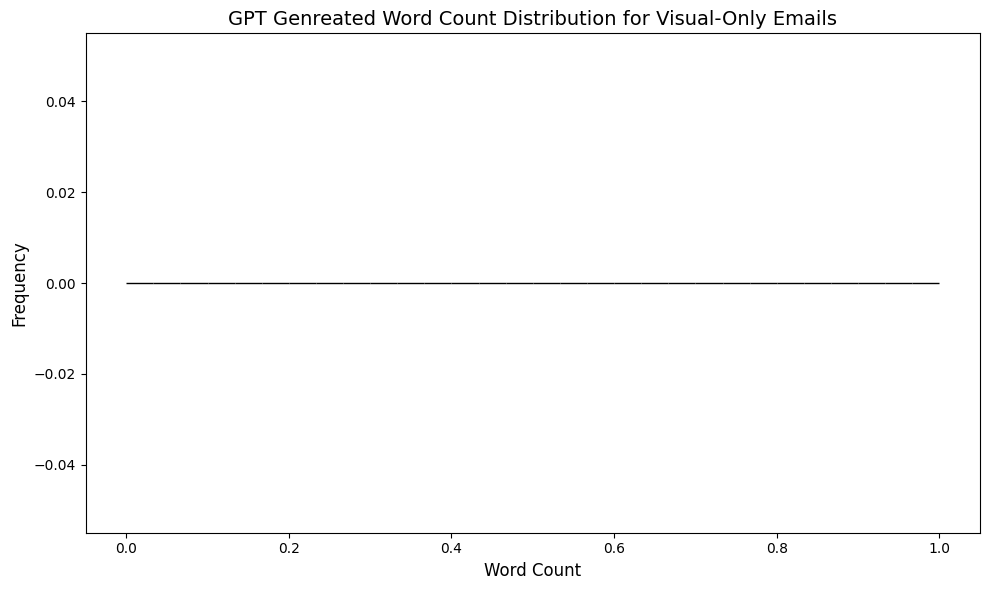

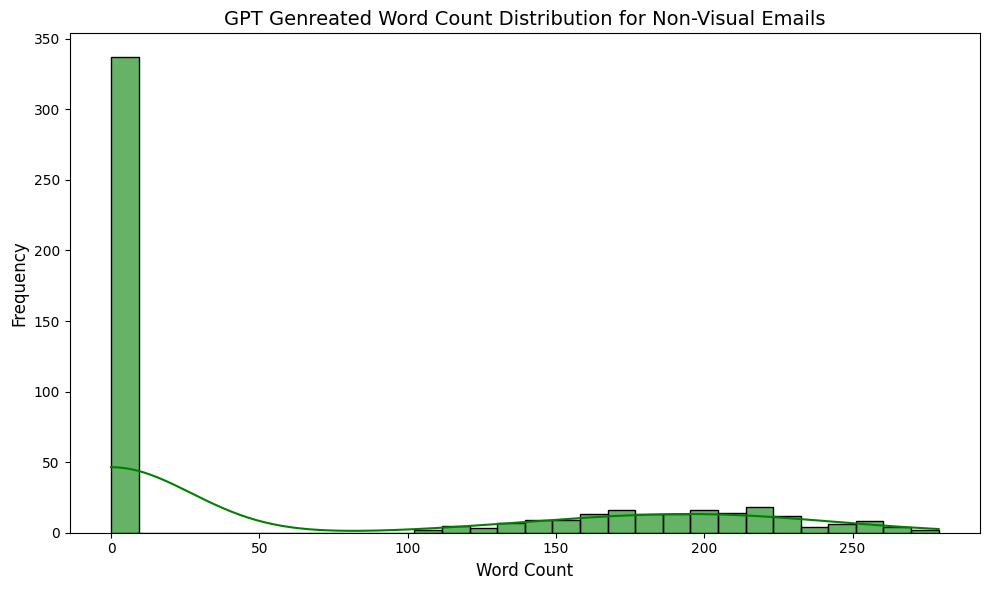

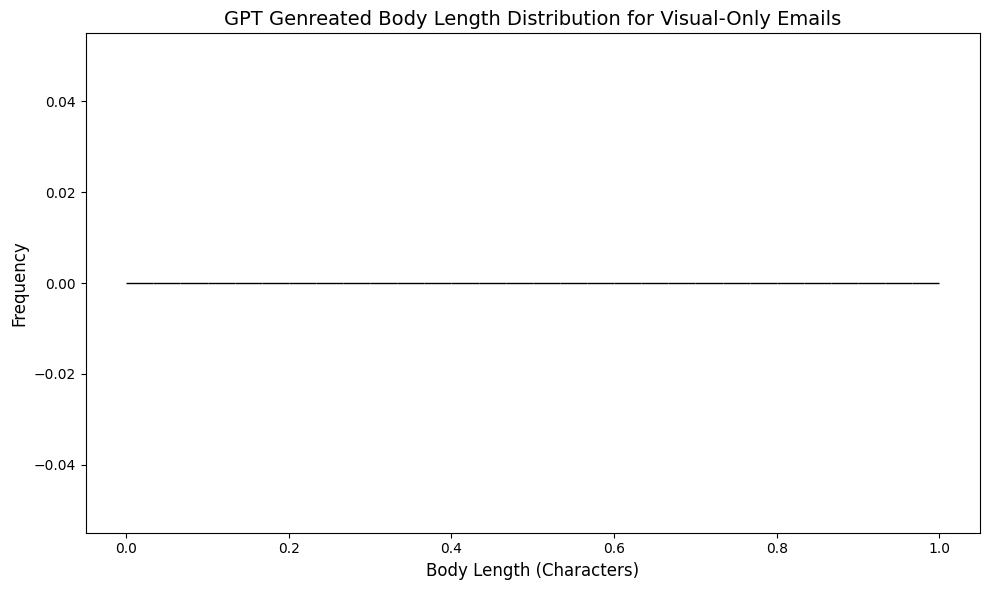

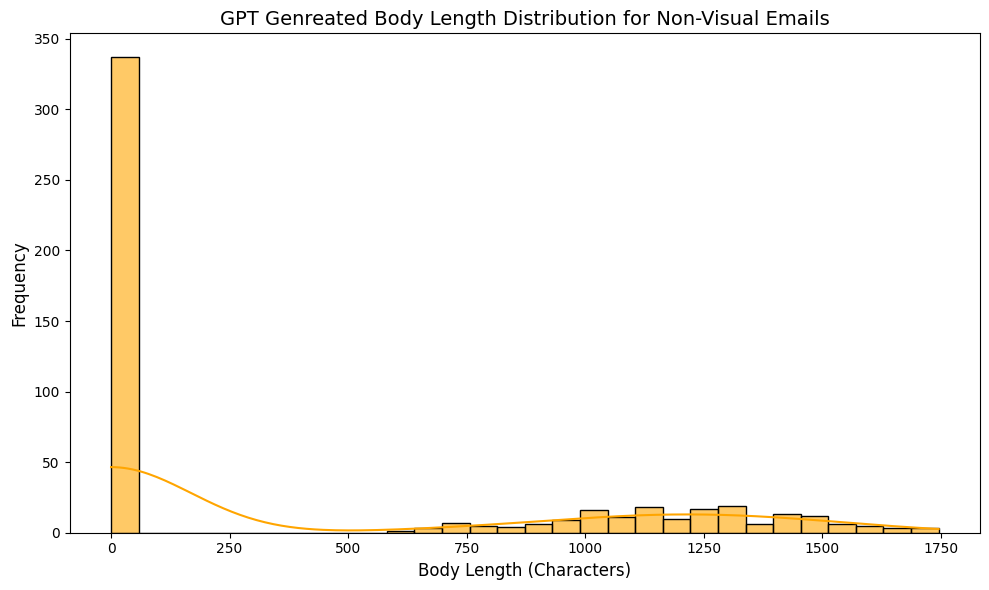

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure the directory to save plots
import os
os.makedirs('plots', exist_ok=True)

# Distribution of word count by topic (separate visualizations)
if 'word_count' in df.columns:
    unique_topics = df['topic'].unique()
    for topic in unique_topics:
        plt.figure(figsize=(10, 6))
        sns.histplot(
            data=df[df['topic'] == topic],
            x='word_count',
            kde=True,
            bins=30,
            color='skyblue',
            alpha=0.6
        )
        plt.title(f'GPT Genreated Word Count Distribution for Topic: {topic}', fontsize=14)
        plt.xlabel('Word Count', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.tight_layout()
        plt.savefig(f'GPT plots/word_count_{topic}.png')  # Save the plot
        plt.show()

# Distribution of body length by topic (separate visualizations)
if 'body_length' in df.columns:
    unique_topics = df['topic'].unique()
    for topic in unique_topics:
        plt.figure(figsize=(10, 6))
        sns.histplot(
            data=df[df['topic'] == topic],
            x='body_length',
            kde=True,
            bins=30,
            color='lightcoral',
            alpha=0.6
        )
        plt.title(f'GPT Genreated Body Length Distribution for Topic: {topic}', fontsize=14)
        plt.xlabel('Body Length (Characters)', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.tight_layout()
        plt.savefig(f'GPT plots/body_length_{topic}.png')  # Save the plot
        plt.show()

# Distribution of word count for visual-only and non-visual emails
if 'word_count' in df.columns and 'is_just_visual' in df.columns:
    for is_visual in [True, False]:
        plt.figure(figsize=(10, 6))
        subset = df[df['is_just_visual'] == is_visual]
        label = 'Visual-Only Emails' if is_visual else 'Non-Visual Emails'
        sns.histplot(
            data=subset,
            x='word_count',
            kde=True,
            bins=30,
            color='purple' if is_visual else 'green',
            alpha=0.6
        )
        plt.title(f'GPT Genreated Word Count Distribution for {label}', fontsize=14)
        plt.xlabel('Word Count', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.tight_layout()
        plt.savefig(f'GPT plots/word_count_{label.replace(" ", "_")}.png')  # Save the plot
        plt.show()

# Distribution of body length for visual-only and non-visual emails
if 'body_length' in df.columns and 'is_just_visual' in df.columns:
    for is_visual in [True, False]:
        plt.figure(figsize=(10, 6))
        subset = df[df['is_just_visual'] == is_visual]
        label = 'Visual-Only Emails' if is_visual else 'Non-Visual Emails'
        sns.histplot(
            data=subset,
            x='body_length',
            kde=True,
            bins=30,
            color='blue' if is_visual else 'orange',
            alpha=0.6
        )
        plt.title(f'GPT Genreated Body Length Distribution for {label}', fontsize=14)
        plt.xlabel('Body Length (Characters)', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.tight_layout()
        plt.savefig(f'GPT plots/body_length_{label.replace(" ", "_")}.png')  # Save the plot
        plt.show()
